In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from matplotlib.colors import LinearSegmentedColormap
from ipywidgets import interact, IntSlider, Dropdown, Checkbox

In [2]:
class Arm:
    def __init__(self, unique_id, x, y, initial_mean, initial_std, variation_func):
        self.unique_id = unique_id
        self.x = x
        self.y = y
        self.initial_mean = initial_mean
        self.initial_std = initial_std
        self.variation_func = variation_func
    
    def get_mean(self, t, x, y):
        distance = np.sqrt((self.x - x)**2 + (self.y - y)**2)
        return self.variation_func(self.initial_mean, t, distance)
    
    def get_std(self, t):
        return self.initial_std
    
    def pull(self, t, x, y):
        return np.random.normal(self.get_mean(t, x, y), self.get_std(t))

In [3]:
class MultiArmedBandit:
    def __init__(self, arms, grid_size=50, strategy='epsilon_greedy', epsilon=0.1, max_speed=0.1, start_x=0.5, start_y=0.5):
        self.arms = arms
        self.n_arms = len(arms)
        self.grid_size = grid_size
        self.strategy = strategy
        self.epsilon = epsilon
        self.max_speed = max_speed
        self.t = 0
        self.x = start_x  # Initial x position of the bandit
        self.y = start_y  # Initial y position of the bandit
    
    def select_action_random(self):
        angle = np.random.uniform(0, 2*np.pi)
        dx = self.max_speed * np.cos(angle)
        dy = self.max_speed * np.sin(angle)
        return min(max(self.x + dx, 0), 1), min(max(self.y + dy, 0), 1)
    
    def select_action_greedy(self, reward_grid):
        # Use gradient ascent to find the best path
        grad_y, grad_x = np.gradient(reward_grid)
        start_x, start_y = int(self.x * (self.grid_size - 1)), int(self.y * (self.grid_size - 1))
        
        path_x, path_y = [start_x], [start_y]
        for step in range(10):  # Take 10 small steps
            current_x, current_y = int(path_x[-1]), int(path_y[-1])
            gx = grad_x[current_y, current_x]
            gy = grad_y[current_y, current_x]
            magnitude = np.sqrt(gx**2 + gy**2)
            if magnitude > 0:
                gx, gy = gx / magnitude, gy / magnitude
            
            new_x = min(max(path_x[-1] + gx, 0), self.grid_size - 1)
            new_y = min(max(path_y[-1] + gy, 0), self.grid_size - 1)
            path_x.append(new_x)
            path_y.append(new_y)
        
        # Interpolate path to respect max_speed
        path_length = np.sum(np.sqrt(np.diff(path_x)**2 + np.diff(path_y)**2))
        if path_length > self.max_speed * (self.grid_size - 1):
            t = np.linspace(0, 1, len(path_x))
            fx = interp1d(t, path_x)
            fy = interp1d(t, path_y)
            t_new = self.max_speed * (self.grid_size - 1) / path_length
            return fx(t_new) / (self.grid_size - 1), fy(t_new) / (self.grid_size - 1)
        else:
            return path_x[-1] / (self.grid_size - 1), path_y[-1] / (self.grid_size - 1)
    
    def select_action_epsilon_greedy(self, reward_grid):
        if np.random.random() < self.epsilon:
            return self.select_action_random()
        else:
            return self.select_action_greedy(reward_grid)
    
    def select_action(self, reward_grid):
        if self.strategy == 'random':
            return self.select_action_random()
        elif self.strategy == 'greedy':
            return self.select_action_greedy(reward_grid)
        elif self.strategy == 'epsilon_greedy':
            return self.select_action_epsilon_greedy(reward_grid)
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
    
    def get_reward(self, start_x, start_y, end_x, end_y):
        # Calculate reward along the path
        t = np.linspace(0, 1, 10)
        path_x = start_x + t * (end_x - start_x)
        path_y = start_y + t * (end_y - start_y)
        
        total_reward = 0
        for x, y in zip(path_x, path_y):
            total_reward += calculate_combined_reward(self.arms, x, y, self.t)
        
        return total_reward / len(t)

    def move_to(self, x, y):
        self.x = x
        self.y = y

def calculate_combined_reward(arms, x, y, t):
    combined_reward = 0
    for arm in arms:
        distance = np.sqrt((arm.x - x)**2 + (arm.y - y)**2)
        influence = 1 / (1 + 5 * distance)
        arm_reward = arm.get_mean(t, x, y)
        combined_reward += arm_reward * influence
    return combined_reward

In [4]:
def run_simulation(mab, n_steps):
    values = {arm.unique_id: 0 for arm in mab.arms}
    counts = {arm.unique_id: 0 for arm in mab.arms}
    cumulative_reward = 0
    rewards = []
    actions = []
    selections = []

    for step in range(n_steps):
        reward_grid = calculate_reward_grid(mab.arms, mab.grid_size, mab.t)
        end_x, end_y = mab.select_action(reward_grid[:,:,-1])  # Use the combined reward grid
        
        # Ensure end_x and end_y are within bounds
        end_x = min(max(end_x, 0), 1)
        end_y = min(max(end_y, 0), 1)
        
        reward = mab.get_reward(mab.x, mab.y, end_x, end_y)

        # Determine which arm had the most influence on this reward
        distances = [np.sqrt((arm.x - end_x)**2 + (arm.y - end_y)**2) for arm in mab.arms]
        closest_arm = mab.arms[np.argmin(distances)]
        arm_id = closest_arm.unique_id

        # Update tracking
        counts[arm_id] += 1
        n = counts[arm_id]
        value = values[arm_id]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        values[arm_id] = new_value

        mab.move_to(end_x, end_y)
        cumulative_reward += reward
        rewards.append(reward)
        actions.append((end_x, end_y))
        selections.append(arm_id)
        mab.t += 1

    return rewards, values, counts, cumulative_reward, selections, actions

def calculate_reward_grid(arms, grid_size, t):
    reward_grid = np.zeros((grid_size, grid_size, len(arms) + 1))
    for i in range(grid_size):
        for j in range(grid_size):
            x, y = i / (grid_size - 1), j / (grid_size - 1)
            for k, arm in enumerate(arms):
                distance = np.sqrt((arm.x - x)**2 + (arm.y - y)**2)
                influence = 1 / (1 + 5 * distance)
                reward_grid[j, i, k] = arm.get_mean(t, x, y) * influence  # Note the j, i order
            reward_grid[j, i, -1] = np.sum(reward_grid[j, i, :-1])  # Combined reward
    return reward_grid

In [5]:
def visualize_true_distribution(arms, grid_size=50, max_time=1000):
    def update(time, view_option):
        reward_grid = calculate_reward_grid(arms, grid_size, time)
        
        plt.figure(figsize=(10, 8))
        if view_option == 'Combined':
            plt.imshow(reward_grid[:,:,-1], origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
            plt.title(f"Combined Spatial Reward Distribution (Time: {time})")
        else:
            arm_index = int(view_option.split()[-1])
            plt.imshow(reward_grid[:,:,arm_index], origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
            plt.title(f"Reward Distribution for Arm {arm_index} (Time: {time})")
        
        plt.colorbar(label='Expected Reward')
        plt.xlabel("X coordinate")
        plt.ylabel("Y coordinate")
        
        # Plot arm locations
        for arm in arms:
            plt.scatter(arm.x, arm.y, color='red', s=50, edgecolor='white')
            plt.annotate(f"Arm {arm.unique_id}", (arm.x, arm.y), xytext=(5, 5), 
                         textcoords='offset points', color='white', fontweight='bold')
        
        plt.show()
    
    # Create an interactive slider and options
    time_slider = IntSlider(min=0, max=max_time, step=1, value=0, description='Time:')
    view_options = ['Combined'] + [f'Arm {i}' for i in range(len(arms))]
    view_dropdown = Dropdown(options=view_options, value='Combined', description='View:')
    
    interact(update, time=time_slider, view_option=view_dropdown)

In [6]:
# Create arms with different initial means, standard deviations, locations, and variation functions
arms = [
    Arm(0, 0.1, 0.2, 0.0, 1, lambda m, t, d: m + 0.01 * t - 0.1 * d),
    Arm(1, 0.4, 0.8, 0.5, 1, lambda m, t, d: m + np.sin(t / 10) * 0.5 - 0.05 * d),
    Arm(2, 0.6, 0.4, 1.0, 1, lambda m, t, d: m - 0.05 * d),
    Arm(3, 0.8, 0.7, 1.5, 1, lambda m, t, d: m + 0.005 * t * np.sin(t / 5) - 0.1 * d),
    Arm(4, 0.5, 0.6, 2.0, 1, lambda m, t, d: m - 0.02 * t - 0.08 * d)
]

In [8]:
# Visualize the reward distribution
visualize_true_distribution(arms)

interactive(children=(IntSlider(value=0, description='Time:', max=1000), Dropdown(description='View:', options…

In [9]:
def visualize_arm_selection_frequencies(all_actions, arms, max_time=1000):
    plt.figure(figsize=(16, 14))
    
    # Create a custom colormap for the path
    colors = ['blue', 'green', 'yellow', 'red']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    # Define line styles for each strategy
    line_styles = {'random': '-', 'greedy': '--', 'epsilon_greedy': '-.'}
    
    def update(time, strategy_view, show_full_path, trail_length):
        plt.clf()
        
        # Calculate reward grid for background
        reward_grid = calculate_reward_grid(arms, 50, time)
        plt.imshow(reward_grid[:,:,-1], origin='lower', extent=[0, 1, 0, 1], cmap='viridis', alpha=0.3)
        plt.colorbar(label='Expected Reward')
        
        strategies_to_show = [strategy_view] if strategy_view != 'All' else all_actions.keys()
        
        for strategy in strategies_to_show:
            actions = all_actions[strategy]
            actions_up_to_time = actions[:time+1]
            
            if not show_full_path:
                actions_up_to_time = actions_up_to_time[-trail_length:]
            
            x, y = zip(*actions_up_to_time)
            
            # Create a color array based on time
            color_array = cmap(np.linspace(0, 1, len(x)))
            
            # Plot the path with changing color
            if show_full_path:
                for i in range(len(x) - 1):
                    plt.plot(x[i:i+2], y[i:i+2], color=color_array[i], 
                             linestyle=line_styles[strategy], linewidth=2, alpha=0.7)
            
            # Plot the final position
            plt.scatter(x[-1], y[-1], color=color_array[-1], s=100, 
                        label=f"{strategy} (current)")
            
            # Plot a trail of recent positions
            trail_start = max(0, len(x) - trail_length)
            plt.plot(x[trail_start:], y[trail_start:], 
                     color='white', linestyle=line_styles[strategy], linewidth=3, alpha=0.5)
            plt.plot(x[trail_start:], y[trail_start:], 
                     color=cmap(0.5), linestyle=line_styles[strategy], linewidth=2, alpha=0.7)
        
        # Plot arm locations
        for arm in arms:
            plt.scatter(arm.x, arm.y, color='red', s=200, marker='*', edgecolor='white', zorder=10)
            plt.annotate(f"Arm {arm.unique_id}", (arm.x, arm.y), xytext=(5, 5), 
                         textcoords='offset points', color='black', fontweight='bold')
        
        plt.title(f"Bandit Path Over Time (Time: {time})")
        plt.xlabel("X coordinate")
        plt.ylabel("Y coordinate")
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Create interactive widgets
    time_slider = IntSlider(min=0, max=max_time, step=1, value=0, description='Time:')
    strategy_dropdown = Dropdown(options=['All'] + list(all_actions.keys()), value='All', description='Strategy:')
    show_full_path = Checkbox(value=False, description='Show Full Path')
    trail_length = IntSlider(min=1, max=100, step=1, value=20, description='Trail Length:')
    
    interact(update, time=time_slider, strategy_view=strategy_dropdown, 
             show_full_path=show_full_path, trail_length=trail_length)

In [10]:
# Simulation parameters
num_steps = 1000
strategies = ['random', 'greedy', 'epsilon_greedy']
start_x, start_y = 0.5, 0.5

In [11]:
# Run simulations for each strategy
results = {}
final_values = {}
final_counts = {}
cumulative_rewards = {}
all_selections = {}
all_actions = {}

for strategy in strategies:
    mab = MultiArmedBandit(arms, strategy=strategy, max_speed=0.1, start_x=start_x, start_y=start_y)
    rewards, values, counts, cumulative_reward, selections, actions = run_simulation(mab, num_steps)
    results[strategy] = rewards
    final_values[strategy] = values
    final_counts[strategy] = counts
    cumulative_rewards[strategy] = cumulative_reward
    all_selections[strategy] = selections
    all_actions[strategy] = actions

In [12]:
# Visualize arm selection frequencies
visualize_arm_selection_frequencies(all_actions, arms, max_time=num_steps-1)

<Figure size 1152x1008 with 0 Axes>

interactive(children=(IntSlider(value=0, description='Time:', max=999), Dropdown(description='Strategy:', opti…

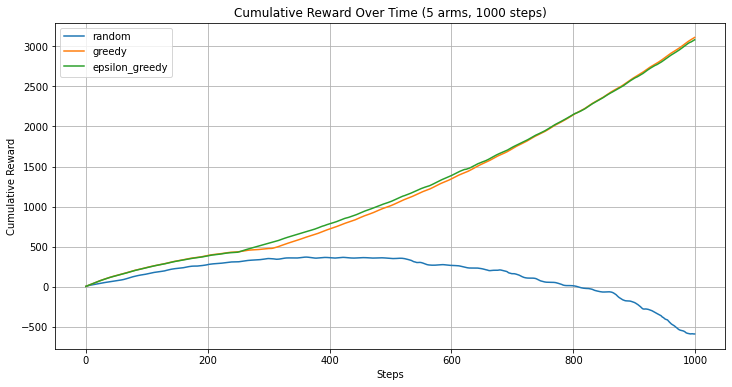

In [13]:
# Plot cumulative reward over time
plt.figure(figsize=(12, 6))
for strategy, rewards in results.items():
    plt.plot(np.cumsum(rewards), label=strategy)

plt.title(f"Cumulative Reward Over Time ({len(arms)} arms, {num_steps} steps)")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()

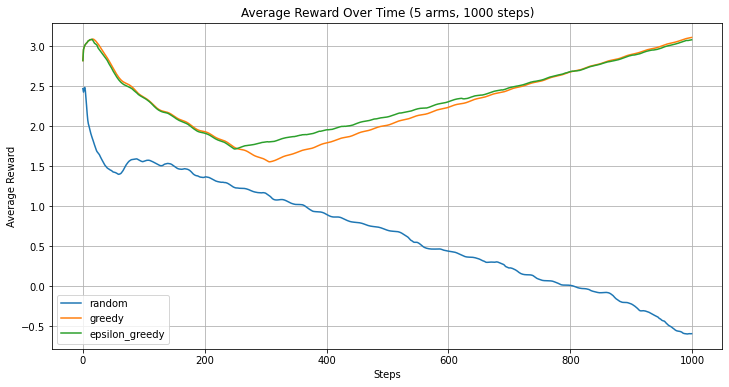

In [14]:
# Plot average reward over time
plt.figure(figsize=(12, 6))
for strategy, rewards in results.items():
    average_reward = np.cumsum(rewards) / (np.arange(len(rewards)) + 1)
    plt.plot(average_reward, label=strategy)

plt.title(f"Average Reward Over Time ({len(arms)} arms, {num_steps} steps)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Print final arm values and counts for each strategy
for strategy in strategies:
    print(f"\nFinal values and visit counts for {strategy} strategy:")
    for arm in arms:
        final_reward = calculate_combined_reward(arms, arm.x, arm.y, num_steps-1)
        print(f"Arm {arm.unique_id} (x={arm.x:.2f}, y={arm.y:.2f}): "
              f"Final reward = {final_reward:.2f}, "
              f"Estimated value = {final_values[strategy][arm.unique_id]:.2f}, "
              f"Visit count = {final_counts[strategy][arm.unique_id]}")
    print(f"Total reward: {cumulative_rewards[strategy]:.2f}")
    print(f"Final bandit position: x={all_actions[strategy][-1][0]:.2f}, y={all_actions[strategy][-1][1]:.2f}")


Final values and visit counts for random strategy:
Arm 0 (x=0.10, y=0.20): Final reward = 4.95, Estimated value = 0.27, Visit count = 65
Arm 1 (x=0.40, y=0.80): Final reward = -6.79, Estimated value = -0.49, Visit count = 97
Arm 2 (x=0.60, y=0.40): Final reward = -5.93, Estimated value = -0.63, Visit count = 368
Arm 3 (x=0.80, y=0.70): Final reward = -7.96, Estimated value = -0.32, Visit count = 365
Arm 4 (x=0.50, y=0.60): Final reward = -16.10, Estimated value = -2.02, Visit count = 105
Total reward: -591.65
Final bandit position: x=0.00, y=0.34

Final values and visit counts for greedy strategy:
Arm 0 (x=0.10, y=0.20): Final reward = 4.95, Estimated value = 3.79, Visit count = 696
Arm 1 (x=0.40, y=0.80): Final reward = -6.79, Estimated value = 0.00, Visit count = 0
Arm 2 (x=0.60, y=0.40): Final reward = -5.93, Estimated value = 1.20, Visit count = 214
Arm 3 (x=0.80, y=0.70): Final reward = -7.96, Estimated value = 0.00, Visit count = 0
Arm 4 (x=0.50, y=0.60): Final reward = -16.10, 